# Question generation tests
Let's test how well we can generate questions for the "clean" CNN data with crowdsourced questions and the noisy NYT data with user-generated questions.

In [1]:
## load data
import pandas as pd
import os
import re
cnn_article_dir = '../../data/CNN_articles/cnn/stories/'
cnn_article_files = list(map(lambda x: os.path.join(cnn_article_dir, x), os.listdir(cnn_article_dir)))
cnn_article_data = pd.DataFrame(list(map(lambda x: ' '.join(list(map(lambda x: x.strip(), open(x, 'r').readlines()))), cnn_article_files)),
                                columns=['article_text'])
article_id_matcher = re.compile('[a-z0-9]+(?=\.story)')
cnn_article_ids = list(map(lambda x: article_id_matcher.search(x).group(0), cnn_article_files))
cnn_article_data = cnn_article_data.assign(**{
    'article_id' : cnn_article_ids
})
display(cnn_article_data.head())

,article_text,article_id
0,(CNN) -- It's been a busy few days in the worl...,23f7ab281ef416e1cdcd9c6fc359278a40a6ba34
1,Ten loveable mutts rescued from the streets of...,a8ac73078f8774a5addac799a22d0634278e79d1
2,Ken Henggeler poured his grief into the thing ...,022713fd20ac0ffd0ddccec6d9389beedd681893
3,Tokyo (CNN) -- Japan's prime minister vowed to...,d62d6364625d1522c55024486ec25851687935e3
4,(CNN) -- The leadership of North Korea appeare...,911597eecfe5d00d39de94f17c2a8400fcb4b994


In [2]:
cnn_question_file = '../../data/CNN_articles/cnn/newsqa-data-v1/newsqa-data-v1.csv'
full_cnn_question_data = pd.read_csv(cnn_question_file, sep=',', index_col=False, usecols=['story_id', 'question', 'is_answer_absent', 'is_question_bad', 'answer_char_ranges'])
full_cnn_question_data.rename(columns={'story_id' : 'article_id'}, inplace=True)
# get article IDs
cnn_article_id_matcher = re.compile('[0-9a-zA-Z]+(?=\.story)')
full_cnn_question_data = full_cnn_question_data.assign(**{
    'article_id' : full_cnn_question_data.loc[:, 'article_id'].apply(lambda x: cnn_article_id_matcher.search(x).group(0))
})
# clean answers
full_cnn_question_data = full_cnn_question_data.assign(**{
    'answer_char_ranges' : full_cnn_question_data.loc[:, 'answer_char_ranges'].apply(lambda x: list(filter(lambda x: x!='None', x.split('|')))),
})

def extract_char_range(txt):
    txt_splits = txt.split(',')
    char_range = list(map(lambda x: list(map(lambda y: int(y), x.split(':'))), txt_splits))
    return char_range
def extract_all_char_ranges(txt):
    char_ranges = list(map(lambda y: extract_char_range(y), txt))
    # flatten lol
    flat_char_ranges = []
    for char_range_i in char_ranges:
        flat_char_ranges += char_range_i
    return flat_char_ranges
full_cnn_question_data = full_cnn_question_data.assign(**{
    'clean_answer_char_ranges' : full_cnn_question_data.loc[:, 'answer_char_ranges'].apply(lambda x: extract_all_char_ranges(x)),
})
# get rid of unclear questions
# NOTE: we may need the different "bad" ratings later when testing word overlap
full_cnn_question_data = full_cnn_question_data[full_cnn_question_data.loc[:, 'is_question_bad']!='?']
full_cnn_question_data = full_cnn_question_data.assign(**{'is_question_bad' : full_cnn_question_data.loc[:, 'is_question_bad'].astype(float)})
# remove bad questions
cnn_question_data = full_cnn_question_data[(full_cnn_question_data.loc[:, 'is_answer_absent']==0.) &
                                           (full_cnn_question_data.loc[:, 'is_question_bad']==0.)]
display(cnn_question_data.head())


,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,[294:297],0.0,0.0,"[[294, 297]]"
1,c48228a52f26aca65c31fad273e66164f047f292,Where was one employee killed?,"[34:60, 1610:1618, 34:60]",0.0,0.0,"[[34, 60], [1610, 1618], [34, 60]]"
2,c65ed85800e4535f4bbbfa2c34d7d9630358d303,who did say South Africa did not issue a visa ...,"[103:127, 114:127, 839:853]",0.0,0.0,"[[103, 127], [114, 127], [839, 853]]"
3,0cf66b646e9b32076513c050edf32a799200c3c2,How many years old was the businessman?,"[538:550, 538:550]",0.0,0.0,"[[538, 550], [538, 550]]"
4,13012604e3203c18df09289dfedd14cde67cf40b,What frightened the families?,"[690:742, 688:791, 630:646]",0.0,0.0,"[[690, 742], [688, 791], [630, 646]]"


In [3]:
## combine article/comment
cnn_article_question_data = pd.merge(cnn_question_data, cnn_article_data, on='article_id')
cnn_article_question_data = cnn_article_question_data[~cnn_article_question_data.loc[:, 'article_text'].apply(lambda x: type(x) is float and np.isnan(x))]
## get answers to validate questions
cnn_article_question_data = cnn_article_question_data.assign(**{
    
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'clean_answers' : cnn_article_question_data.apply(lambda x: list(map(lambda y: x.loc['article_text'][y[0]:y[1]], x.loc['clean_answer_char_ranges'])), axis=1)
})

In [4]:
print(f'{cnn_article_question_data.shape[0]} questions')

63672 questions


In [5]:
display(cnn_article_question_data.head(5))

,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges,article_text,clean_answers
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,[294:297],0.0,0.0,"[[294, 297]]","NEW DELHI, India (CNN) -- A high court in nort...",[ict]
1,42d01e187213e86f5fe617fe32e716ff7fa3afc4,When was Pandher sentenced to death?,"[261:271, 258:271, 261:271]",0.0,0.0,"[[261, 271], [258, 271], [261, 271]]","NEW DELHI, India (CNN) -- A high court in nort...","[bruary. T, February. T, bruary. T]"
2,42d01e187213e86f5fe617fe32e716ff7fa3afc4,The court aquitted Moninder Singh Pandher of w...,"[26:33, 624:640]",0.0,0.0,"[[26, 33], [624, 640]]","NEW DELHI, India (CNN) -- A high court in nort...","[A high , murder of the 1]"
3,42d01e187213e86f5fe617fe32e716ff7fa3afc4,who was acquitted,"[195:218, 195:218]",0.0,0.0,"[[195, 218], [195, 218]]","NEW DELHI, India (CNN) -- A high court in nort...","[ninder Singh Pandher wa, ninder Singh Pandher..."
4,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was Moninder Singh Pandher acquitted for?,"[129:192, 129:151, 133:151]",0.0,0.0,"[[129, 192], [129, 151], [133, 151]]","NEW DELHI, India (CNN) -- A high court in nort...","[the killing of a teen in a case dubbed ""the h..."


### Train model
Let's try an actual trained QA model with all the bells/whistles first, downloaded from [here](https://github.com/patil-suraj/question_generation.git).

In [6]:
import sys
if('question_generation/' not in sys.path):
    sys.path.append('question_generation/')
## NOTE need to run pipeline once to download (expensive!!) models
from pipelines import pipeline
# print(help(pipeline))
question_pipeline = pipeline('question-generation')

In [7]:
## test short text
text = "Python is an interpreted, high-level, general-purpose programming language. Created by Guido van Rossum \
and first released in 1991, Python's design philosophy emphasizes code \
readability with its notable use of significant whitespace."
text_question = question_pipeline(text)
print(text_question)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/transformers/tokenization_t5.py:183: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


[{'answer': 'Python', 'question': 'What is an interpreted, high-level, general-purpose programming language?'}, {'answer': 'Guido van Rossum', 'question': 'Who created Python?'}]


In [8]:
# test with article, which can be longer
test_cnn_article_question_data = cnn_article_question_data.iloc[0, :]
test_article = test_cnn_article_question_data.loc['article_text']
test_gold_question = test_cnn_article_question_data.loc['question']
print(f'{test_article[:300]}...')
test_article_questions = question_pipeline(test_article)
print(f'generated questions = {test_article_questions}')
print(f'gold question = {test_gold_question}')

NEW DELHI, India (CNN) -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed "the house of horrors."  Moninder Singh Pandher was sentenced to death by a lower court in February.  The teen was one of 19 victims...
generated questions = [{'answer': 'the house of horrors', 'question': 'What was the name of the case that was acquitted by a high court in northern India?'}, {'answer': 'February', 'question': 'When was Moninder Singh Pandher sentenced to death?'}, {'answer': '19', 'question': 'How many victims did Moninder Singh Pandher have?'}, {'answer': 'Sikandar B. Kochar', 'question': "Who was Moninder Singh Pandher's lawyer?"}, {'answer': 'Surinder Koli', 'question': "Who was Pandher's domestic employee?"}, {'answer': 'Koli', 'question': "Who's death sentence was upheld by the high court?"}, {'answer': 'Noida', 'question': "Where was Pandher's home found?"}, {'answer': 'house of horrors', 'questio

Even though the wording is different, we see that the gold question is captured in at least one of the generated questions (`How many victims...`).

### Generate, evalute questions for articles

Let's try generating questions for all the articles and see how potentially useful they would be. They may be restricted to within-sentence reasoning and therefore not too complicated.

In [51]:
from tqdm import tqdm
tqdm.pandas()
def generate_questions(text, question_model):
    questions = []
    try:
        questions = question_model(text)
    except Exception as e:
        print(f'no questions because error {e}')
    return questions
article_var = 'article_text'
cnn_article_data_with_questions = cnn_article_data[cnn_article_data.loc[:, 'article_id'].isin(cnn_article_question_data.loc[:, 'article_id'].values)]
import numpy as np
np.random.seed(123)
# sample_size = 500
sample_size = cnn_article_data_with_questions.shape[0]
sample_cnn_article_data_with_questions = cnn_article_data_with_questions.loc[np.random.choice(cnn_article_data_with_questions.index, sample_size, replace=False), :]
sample_cnn_article_generated_questions = sample_cnn_article_data_with_questions.loc[:, article_var].progress_apply(lambda x: generate_questions(x, question_pipeline))

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 12/11852 [00:16<5:03:36,  1.54s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/transformers/tokenization_t5.py:183: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
 26%|██▌       | 3106/11852 [1:11:28<3:47:07,  1.56s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
# ## combine with other data 
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_questions.reset_index(name='article_questions').drop('index', axis=1).assign(**{'article_id' : sample_cnn_article_data_with_questions.loc[:, 'article_id'].values})
# # display(sample_cnn_article_generated_question_data.head())
# sample_cnn_article_generated_question_data = pd.merge(sample_cnn_article_generated_question_data, cnn_article_question_data, on='article_id', how='left')
display(sample_cnn_article_generated_question_data.head())
## save to file
out_file = '../../data/CNN_articles/cnn/article_generated_question_data.tsv'
sample_cnn_article_generated_question_data.to_csv(out_file, sep='\t', index=False)

,article_questions,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges,article_text,clean_answers,best_question_score,best_question
49617,"[{'answer': 'Stephen Hawking', 'question': 'Wh...",511fa443bdaabb7845aba2cb69737c96d7efd757,who is the world's greatest living scientist?,"[72:88, 72:88]",0.0,0.0,"[[72, 88], [72, 88]]","LONDON, England (CNN) -- Cosmologist, theoreti...","[Stephen Hawking , Stephen Hawking ]",1.0,who is the world's greatest living scientist?
17185,"[{'answer': '2-0', 'question': 'When did Inter...",b0a5fb32fb2d97a4ff49362a77aa7288914b44b6,who beat lazio 2-0?,"[10:22, 10:22]",0.0,0.0,"[[10, 22], [10, 22]]",(CNN) -- Inter Milan stayed on course for the...,"[Inter Milan , Inter Milan ]",1.0,who beat lazio 2-0?
17039,"[{'answer': 'Christmas Eve', 'question': 'When...",4872125bdb96f745b14fea0f09c3f3773e2fe551,who argued over gambling debt?,"[20:62, 288:326, 20:62]",0.0,0.0,"[[20, 62], [288, 326], [20, 62]]",Washington (CNN) -- Two Washington Wizards bas...,"[Two Washington Wizards basketball players , e...",1.0,who argued over gambling debt?
56153,"[{'answer': 'John Albert Gardner III', 'questi...",85a7aaa5b67a30872d4f47f0ec930465bfb442e8,what did gardner plead guilty to?,"[1609:1655,1743:1763,1766:1778, 368:378, 1743:...",0.0,0.0,"[[1609, 1655], [1743, 1763], [1766, 1778], [36...",(CNN) -- Admitted killer John Albert Gardner I...,[go-area teens in a deal with prosecutors that...,1.0,what did gardner plead guilty to?
47413,"[{'answer': 'Department of Veterans Affairs', ...",ff0e56f0be51bc47d57b7e162711eef48e43a1b3,how many veterans are homeless?,"[831:839, 831:839]",0.0,0.0,"[[831, 839], [831, 839]]","Washington (CNN) -- With a simple, declarative...","[veterans, veterans]",1.0,how many veterans are homeless?


How much do these questions overlap with the "gold" questions?

Let's test for maximum overlap: we assume that higher overlap among questions means more likelihood that the questions are identical.

In [55]:
from nltk.translate.bleu_score import sentence_bleu
def compute_text_bleu(txt_1, txt_2, weights):
    score = sentence_bleu([txt_1], txt_2, weights=weights)
    return score
def compute_max_sent_score(test_questions, gold_question, weights):
    test_question_text = list(map(lambda x: x['question'].lower(), test_questions))
    test_question_bleu_scores = np.array(list(map(lambda x: compute_text_bleu(x, gold_question, weights=weights), test_question_text)))
    max_score = np.max(test_question_bleu_scores)
    max_score_question = test_question_text[np.where(test_question_bleu_scores == max_score)[0][0]]
    return max_score, max_score_question
# BLEU-1
bleu_weights = [1.0, 0., 0., 0.]
## first test: do the "best" matches actually make sense?
for idx_i, data_i in sample_cnn_article_generated_question_data.drop_duplicates('article_id').iloc[:10, :].iterrows():
    print(f'gold question = {data_i.loc["question"]}')
    print(f'generated questions = {data_i.loc["article_questions"]}')
    best_question_score_i, best_question_i = compute_max_sent_score(data_i.loc['article_questions'], 
                                                                    data_i.loc['question'], 
                                                                    weights=bleu_weights)
    print(f'best question = <{best_question_i}> (score={best_question_score_i})')
    # print(compute_text_bleu(sample_cnn_article_generated_question_data.iloc[0, :].loc['article_questions'][0]['question'], 
    #                         sample_cnn_article_generated_question_data.iloc[0, :].loc['question'], 
    #                         weights=bleu_weights))

gold question = when these soldiers return
generated questions = [{'answer': '4,000', 'question': 'How many troops will the United States withdraw in Iraq by the end of October?'}, {'answer': 'next year', 'question': 'What year is the U.S. on track to end its combat mission in Iraq?'}, {'answer': 'Ray Odierno', 'question': 'Who is expected to tell the House of Representatives Armed Services Committee that there has been a significant drop in violence in Iraq recently?'}, {'answer': 'August 31, 2010', 'question': 'When will the U.S. combat mission in Iraq end?'}, {'answer': '35,000 to 50,000', 'question': 'How many support troops did Obama plan to keep on the ground in Iraq?'}, {'answer': '124,000', 'question': 'How many troops are there in Iraq today?'}, {'answer': '120,000', 'question': 'How many troops are in Iraq by the end of October?'}, {'answer': 'statistics', 'question': "What is Odierno's view of Iraq's violence?"}, {'answer': '85 percent', 'question': 'What percentage of Iraqi

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

The "best score" questions do get some words correct (`tried` vs. `trial`) but they are still missing the mark (low precision) and the generated questions often don't contain the gold question anyway (low recall). Some of the questions require multiple hops of reasoning and some questions are also more broad than the model is expecting (`what happened to jim carroll`). We may need more complicated models!

Let's look at the questions with the highest scores and determine if there is a cutoff that we can use for identifying actual matches.

In [64]:
# bleu_weights = [1.0, 0., 0., 0.]
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_question_data.assign(**{
#     'best_question_score' : sample_cnn_article_generated_question_data.apply(lambda x: compute_max_sent_score(x.loc['article_questions'], x.loc['question'], weights=bleu_weights), axis=1)
# })
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_question_data.assign(**{
#     'best_question' : sample_cnn_article_generated_question_data.loc[:, 'best_question_score'].apply(lambda x: x[1]),
#     'best_question_score' : sample_cnn_article_generated_question_data.loc[:, 'best_question_score'].apply(lambda x: x[0]),
# })
top_k_questions = 10
quantiles = [0.7, 0.8, 0.9, 1.0]
sample_cnn_article_generated_question_data.sort_values('best_question_score', inplace=True, ascending=False)
for quantile_i in quantiles:
    print(f'*~*~*~* testing quantile={quantile_i} *~*~*~*')
    data_i = sample_cnn_article_generated_question_data[sample_cnn_article_generated_question_data.loc[:, 'best_question_score'] >= quantile_i]
    for j, (idx_j, data_j) in enumerate(data_i.drop_duplicates('article_id').tail(top_k_questions).iterrows()):
        print(f'article # {j}')
        print(f'\tgold question = {data_j.loc["question"]}')
        print(f'\tgenerated questions = {data_j.loc["article_questions"]}')
        print(f'\tbest question = <{data_j.loc["best_question"]}> (score={data_j.loc["best_question_score"]})')

*~*~*~* testing quantile=0.7 *~*~*~*
article # 0
	gold question = What were the pair accused of?
	generated questions = [{'answer': 'more than 1,000', 'question': 'How many prisoners were thrown out of planes during the "dirty war"?'}, {'answer': '2006', 'question': 'When was a demonstration held?'}, {'answer': 'Julio Alberto Poch', 'question': 'Who is the former Navy Lt. who has been held in Spain without bail since his arrest in Valencia?'}, {'answer': '1976-83', 'question': 'In what years did the right-wing dictatorship take place?'}, {'answer': 'Bariloche', 'question': 'Where was Emir Sisul Hess arrested?'}, {'answer': 'Friday', 'question': 'When was the initial hearing for Sisul Hess held?'}, {'answer': 'piloting aircraft', 'question': 'What are the two men accused of hurling prisoners to their deaths in the Atlantic Ocean or the Rio Plata?'}, {'answer': 'political views', 'question': 'What did the leftists run afoul of the dictatorship because of?'}, {'answer': 'secret prisons', 

For how many articles did the generated questions contain the gold question (~recall)?

- Score 0.7: 0 0 0 0 0 0 1 0 1 0 = 20%
- Score 0.8: 0 0 0 0 0 0 0 0 0 0 = 0% 
- Score 0.9: 1 0 1 1 1 1 1 1 1 1 = 90%
- Score 1.0: 1 1 1 1 1 1 1 1 1 1 = 100%

90% match is a cutoff that maximizes precision/recall. Let's look at the overall distribution of scores to understand coverage.

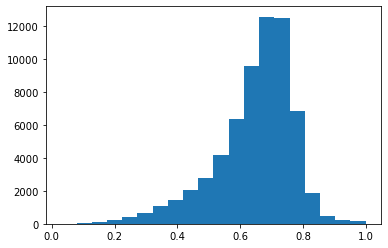

430/63672 questions >= 0.9


In [69]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sample_cnn_article_generated_question_data.loc[:, 'best_question_score'], bins=20)
plt.show()
question_score_cutoff = 0.9
print(f'{sample_cnn_article_generated_question_data[sample_cnn_article_generated_question_data.loc[:, "best_question_score"] >= question_score_cutoff].shape[0]}/{sample_cnn_article_generated_question_data.shape[0]} questions >= {question_score_cutoff}')

OK! We have ~ 3% of generated questions that match the actual question. We should try to increase that!

### Re-train question model
Let's try to fine-tune the model using the training procedure explained [here](https://github.com/patil-suraj/question_generation#training). We should try to get the model to learn some of the basic logic required to put questions together for the CNN data before moving on prematurely to the NYT data.

In [1]:
## reload data fml
import pandas as pd
cnn_article_question_data = pd.read_csv('../../data/CNN_articles/cnn/article_question_data.tsv', sep='\t', index_col=False)
display(cnn_article_question_data.head())

,article_id,question,is_answer_absent,is_question_bad,article_text,question_tokens,article_tokens,publisher,dummy_comment_id,article_question_bleu
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['What', 'was', 'the', 'amount', 'of', 'childr...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,0,0.017422
1,42d01e187213e86f5fe617fe32e716ff7fa3afc4,When was Pandher sentenced to death?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['When', 'was', 'Pandher', 'sentenced', 'to', ...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,1,0.017422
2,42d01e187213e86f5fe617fe32e716ff7fa3afc4,The court aquitted Moninder Singh Pandher of w...,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['The', 'court', 'aquitted', 'Moninder', 'Sing...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,2,0.020906
3,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was Moninder Singh Pandher acquitted for?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['What', 'was', 'Moninder', 'Singh', 'Pandher'...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,3,0.020906
4,42d01e187213e86f5fe617fe32e716ff7fa3afc4,Who was sentenced to death in February?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['Who', 'was', 'sentenced', 'to', 'death', 'in...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,4,0.020906


In [2]:
import os
# https://github.com/patil-suraj/question_generation/blob/master/prepare_data.py
class DataProcessor:
    """
    Process data for conversion to matrix format.
    """
    def __init__(self, tokenizer, model_type="t5", max_source_length=512, max_target_length=32):
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.model_type = model_type
        self.hl_token = "<hl>"
        
        if model_type == "t5":
            self.sep_token = "<sep>"
        elif model_type == "bart":
            self.sep_token = "<sep>"
        else:
            self.sep_token = "[SEP]"
  
    def process(self, dataset):
        if self.model_type == "t5":
            dataset = dataset.map(self._add_eos_examples)
        
        dataset = dataset.map(self._add_special_tokens)
        dataset = dataset.map(self._convert_to_features, batched=True)
        
        return dataset
  
    def _add_eos_examples(self, example):
        example['source_text'] = example['source_text'] + " </s>"
        example['target_text'] = example['target_text'] + " </s>"
        return example
  
    def _add_special_tokens(self, example):
        example['source_text'] = example['source_text'].replace("{hl_token}", self.hl_token)    
        example['target_text'] = example['target_text'].replace("{sep_token}", self.sep_token)
        return example
  
    # tokenize the examples
    def _convert_to_features(self, example_batch):
        source_encoding = self.tokenizer.batch_encode_plus(
            example_batch['source_text'],
            max_length=self.max_source_length,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True, 
        )
        target_encoding = self.tokenizer.batch_encode_plus(
            example_batch['target_text'],
            max_length=self.max_target_length,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True, 
        )

        encodings = {
            'source_ids': source_encoding['input_ids'], 
            'target_ids': target_encoding['input_ids'],
            'attention_mask': source_encoding['attention_mask'],
        }

        return encodings

import torch
import numpy as np
    
def prepare_question_data(data, out_dir, tokenizer, train_pct=0.8):
    # change to clean source/target format
    clean_data = data.loc[:, ['article_text', 'question']].rename(columns={'article_text' : 'source_text', 'question' : 'target_text'})
    # split train/val
    np.random.seed(123)
    N = clean_data.shape[0]
    N_train = int(N*train_pct)
    np.random.shuffle(clean_data.values)
    clean_data_train = clean_data.iloc[:N_train, :]
    clean_data_val = clean_data.iloc[N_train:, :]
    clean_data_train_out_file = os.path.join(out_dir, 'article_question_generation_train_data.csv')
    clean_data_val_out_file = os.path.join(out_dir, 'article_question_generation_val_data.csv')
    clean_data_train.to_csv(clean_data_train_out_file, sep=',', index=False)
    clean_data_val.to_csv(clean_data_val_out_file, sep=',', index=False)
    # reload data into correct format lol
    train_data_set = nlp.load_dataset('csv', data_files=clean_data_train_out_file)
    val_data_set = nlp.load_dataset('csv', data_files=clean_data_val_out_file)
#     tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    # get max lengths
    source_text_tokens = clean_data.loc[:, 'source_text'].apply(lambda x: tokenizer.tokenize(x))
    target_text_tokens = clean_data.loc[:, 'target_text'].apply(lambda x: tokenizer.tokenize(x))
#     max_source_length = max(source_text_tokens.apply(lambda x: len(x)))
#     max_target_length = max(target_text_tokens.apply(lambda x: len(x)))
    # tmp debugging: shorten source/target
    max_source_length = 1024
    max_target_length = 64
    data_processor = DataProcessor(tokenizer=tokenizer,
                                   model_type='bert',
                                   max_source_length=max_source_length,
                                   max_target_length=max_target_length)
    train_data = data_processor.process(train_data_set)
    val_data = data_processor.process(val_data_set)
    columns = ["source_ids", "target_ids", "attention_mask"]
    train_data.set_format(type='torch', columns=columns)
    val_data.set_format(type='torch', columns=columns)
#     print(f'train data {train_data}')
    train_data_out_file = os.path.join(out_dir, 'article_question_generation_train_data.pt')
    val_data_out_file = os.path.join(out_dir, 'article_question_generation_val_data.pt')
    torch.save(train_data, train_data_out_file)
    torch.save(val_data, val_data_out_file)
    # save tokenizer?? sure
    tokenizer_out_file = os.path.join(out_dir, 'BART_tokenizer.pt')
    torch.save(tokenizer, tokenizer_out_file)

In [3]:
import nlp
import transformers
from transformers import BartTokenizer
out_dir = '../../data/CNN_articles/cnn/'
train_pct = 0.8
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
# TODO: increase vocab size to include named entities? 
# TODO: shrink data to debug training
prepare_question_data(cnn_article_question_data.copy().head(2000), out_dir, tokenizer=tokenizer, train_pct=train_pct)

Using custom data configuration default


Dataset csv downloaded and prepared to /home/ianbstew/.cache/huggingface/datasets/csv/default-9b6b2365e2270632/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


Using custom data configuration default


Dataset csv downloaded and prepared to /home/ianbstew/.cache/huggingface/datasets/csv/default-675cf03b411ee895/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


Now let's train a model to generate the questions.

In [4]:
# stolen from https://github.com/patil-suraj/question_generation/blob/master/run_qg.py
import sys
if('question-generation' not in sys.path):
    sys.path.append('question-generation')
import torch
# load models
from transformers import BertModel, BertTokenizer, BartTokenizer, AutoModelForSeq2SeqLM
cache_dir = '../../data/CNN_articles/cnn/model_cache/'
# model = BertModel.from_pretrained('bert-base-cased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = torch.load('../../data/CNN_articles/cnn/BART_tokenizer.pt')
# print(len(tokenizer))
model = AutoModelForSeq2SeqLM.from_pretrained(
        'facebook/bart-base',
        cache_dir=cache_dir,
    )
model.resize_token_embeddings(len(tokenizer))
device = torch.device('cuda:0')
model.to(device)

## load data
import os
data_dir = '../../data/CNN_articles/cnn/'
train_file = os.path.join(data_dir, 'article_question_generation_train_data.pt')
val_file = os.path.join(data_dir, 'article_question_generation_val_data.pt')
train_dataset = torch.load(train_file)
val_dataset = torch.load(val_file)
train_dataset = train_dataset['train']
val_dataset = val_dataset['train']

# get max source/target len
max_source_len = len(train_dataset['source_ids'][0])
max_target_len = len(train_dataset['target_ids'][0])

# initialize data collator
import sys
if('question_generation' not in sys.path):
    sys.path.append('question_generation')
from data_collator import T2TDataCollator
model_type = 'bart'
data_collator = T2TDataCollator(
    tokenizer=tokenizer,
    model_type=model_type,
    mode="training",
    using_tpu=False
)
# #  Initialize Trainer
# need data argument class ;_;
from dataclasses import field
from typing import Dict, List, Optional
from transformers.training_args import TrainingArguments
class DataArguments(TrainingArguments):
    train_file_path: str = field(
        metadata={"help": "Path for cached train dataset"},
    )
    valid_file_path: str = field(
        metadata={"help": "Path for cached valid dataset"},
    )
    data_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Path for data files"}, 
    )
    task: Optional[str] = field(
        default=None,
        metadata={"help": "Which task 'qa', 'qg', 'e2e_qg', 'ans_ext', 'multi'. 'multi' means 'qa', 'qg', 'ans_ext' tasks"}, 
    )
    qg_format: Optional[str] = field(
        default='prepend_qg_format',
        metadata={"help": "How to format inputs for que generation, 'highlight_qg_format' or 'prepend_qg_format'"}, 
    )
    max_source_length: Optional[int] = field(
        default=512,
        metadata={"help": "Max input length for the source text"},
    )
    max_target_length: Optional[int] = field(
        default=32,
        metadata={"help": "Max input length for the target text"},
    )
    n_gpu : Optional[int] = field(
        default=1,
    )
# training_arg_dict = {
#     'train_file_path' : 'article_question_generation_train_data.pt',
#     'valid_file_path' : 'article_question_generation_val_data.pt',
#     'data_dir' : data_dir,
#     'task' : 'qg',
#     'max_source_length' : max_source_len,
#     'max_target_length' : max_target_len,
#     'n_gpu' : 1,
#     'seed' : 123,
# }
data_dir = '../../data/CNN_articles/cnn/'
out_dir = '../../data/CNN_articles/cnn/question_generation_model/'
import os
if(not os.path.exists(out_dir)):
    os.mkdir(out_dir)
training_args = DataArguments(out_dir)
training_args.train_file_path = 'article_question_generation_train_data.pt',
training_args.valid_file_path = 'article_question_generation_val_data.pt'
training_args.data_dir = data_dir
training_args.task = 'qg'
training_args.max_source_length = max_source_len
training_args.max_target_length = max_target_len
training_args.n_gpu = 1 
# training_args.device = 'cuda:1' 
training_args.seed = 123
training_args.disable_tqdm = False
training_args.local_rank = -1
training_args.output_dir = out_dir
training_args.num_train_epochs = 20
# training_args.max_steps = 1
training_args.fp16 = False
training_args.label_names = None
training_args.per_device_train_batch_size = 4
training_args.per_device_eval_batch_size = 4
# training_args.train_batch_size = 32
# training_args.eval_batch_size = 32
training_args.gradient_accumulation_steps = 4
training_args.learning_rate = 1e-4
training_args.dataloader_drop_last = False
training_args.dataloader_num_workers = 8
# default values from here lol https://github.com/huggingface/transformers/blob/49759c0cda29ab614b81e0869972c99f2edba7aa/src/transformers/training_args.py
training_args.weight_decay = 0.01
training_args.adam_beta1 = 0.9
training_args.adam_beta2 = 0.999
training_args.adam_epsilon = 1e-8
training_args.warmup_steps = 0
# limits number of checkpoints => 1 GB per optimizer file ;_;
training_args.save_total_limit = 2
model_args = {
    'label_smoothing' : 0,
}
## TODO: prevent model from saving optimizer during every 500 training steps!!
from trainer import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
#     prediction_loss_only=True,
    label_smoothing=model_args['label_smoothing'],
)

In [ ]:
## train
import torch
torch.cuda.empty_cache()
model_dir = '../../data/CNN_articles/cnn/question_generation_model/'
trainer.train(
    model_path=model_dir,
)
trainer.save_model()

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

Step,Training Loss
500,1.795577


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

Now that training is "done," let's evaluate!!

In [28]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/CNN_articles/cnn/model_cache/'
# generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
trained_model_state_dict_file = '../../data/CNN_articles/cnn/question_generation_model/pytorch_model.bin'
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)

In [17]:
## load evaluation data
val_data_file = '../../data/CNN_articles/cnn/article_question_generation_val_data.pt'
val_data = torch.load(val_data_file)['train']

In [87]:
## do beam search
from tqdm import tqdm
import torch
def generate_predictions(model, data, device_name='cuda:0'):
    num_beams = 4
    max_decoding_length = 64
    length_penalty = 1
    device = torch.device(device_name)
    model.to(device)
    pred_text = []
    for batch_i in tqdm(data):
        source_i = batch_i['source_ids']
        attention_i = batch_i['attention_mask']
        # fix type in case of difference
        if(type(source_i) is list):
            source_i = torch.LongTensor(source_i)
        if(type(attention_i) is list):
            attention_i = torch.Tensor(attention_i)
        output_i = model.generate(
            input_ids=source_i.to(device).reshape(1,-1), 
            attention_mask=attention_i.to(device).reshape(1,-1),
            num_beams=num_beams,
            max_length=max_decoding_length,
            length_penalty=length_penalty,
        )
        prediction = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_i]
        pred_text.extend(prediction)
    return pred_text

In [ ]:
device_name = 'cuda:0'
pred_text = generate_predictions(generation_model, val_data, device_name)

In [45]:
def compare_pred_text_with_target(data, pred_text, tokenizer):
    special_tokens = set(['<pad>', '<s>', '</s>'])
    for i, (batch_i, pred_text_i) in enumerate(zip(data, pred_text)):
        source_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['source_ids']]
        target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
        # cleanup
        source_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, source_text_i)))
        target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
        print('*~*~*~*~*~*')
        print(f'source text = {source_text_i[:300]}...')
        print(f'target text = {target_text_i}')
        print(f'pred text = {pred_text_i}')

In [34]:
compare_pred_text_with_target(val_data, pred_text, tokenizer)

*~*~*~*~*~*
source text = J oh ann es burg  ( CNN )  --  M iff ed  by  a  visa  delay  that  led  the  Dalai  Lama  to  cancel  a  trip  to  South  Africa ,  Archbishop  Desmond  Tut u  lashed  out  at  his  government  Tuesday ,  saying  it  had  acted  worse  than  apartheid  regimes  and  had  forgotten  all  that  the  n...
target text = Who  does  the  African  National  Congress  say  should  calm  down ?
pred text = who says the government is acting worse than apartheid regime?
*~*~*~*~*~*
source text = ( CNN )  --  Verizon  has  been  touted  as  having  the  biggest ,  bad dest ,  fastest  4 G  around .  It 's  been  this  way  since  the  carrier  debuted  its  LTE  network  in  late  2010 .    But  now  that  AT & T  has  joined  the  LTE  game ,  consumers  looking  for  top  speeds  might  co...
target text = Which  network  is  currently  the  largest  in  terms  of  nationwide  coverage ?
pred text = What does the report show
*~*~*~*~*~*
source text = LOS  ANGEL ES ,  Ca

*~*~*~*~*~*
source text = ( CNN )  --  World - record  signing  Crist iano  Ronaldo  scored  on  his  debut  as  Real  Madrid  kicked  off  the  Spanish  football  season  with  a  shaky  3 - 2  victory  at  home  to  Dep ort ivo  La  Cor una  on  Saturday  night .    Crist iano  Ronaldo  celebrates  after  paying  off  a  s...
target text = What  was  the  score ?
pred text = Who kicked off Spanish football season with 3-2 win?
*~*~*~*~*~*
source text = ( CNN )  --  The  driver  who  collided  with  a  vehicle  driven  by  Olympic  swim mer  Michael  Phelps  will  be  cited  for  failure  to  stop  at  a  red  light ,  police  said  Friday .    Michael  Phelps '  black  Cadillac  Esc al ade  collided  with  another  vehicle  at  an  intersection , ...
target text = How  many  vehicles  were  involved  in  the  crash ?
pred text = What will Michael Phelps be cited for?
*~*~*~*~*~*
source text = NEW  YORK  ( CNN )  --  B idding  failed  to  meet  expectations  Saturday  on  a  uniquely 

*~*~*~*~*~*
source text = NEW  YORK  ( CNN )  --  Cool  suit ?  Check .  Ed gy  spect acles ?  Check .  Warm  vocal  chords ?  Check .    Gary  Go  uses  iPhone  apps  to  help  him  compose  new  material  --  and  provide  instant  accompan iment .    Instrument ?  Power ing  up  iPhone ...    These  days ,  British  singe...
target text = What  does  Gary  Go  use  for  musical  accompan iment ?
pred text = What nationality is Gary Go?
*~*~*~*~*~*
source text = ( CNN )  --  Paul  Harvey ,  the  legendary  radio  host  whose  career  sharing  " the  rest  of  the  story "  with  listeners  sp anned  more  than  70  years ,  has  died ,  according  to  ABC  Radio  Networks .    Paul  Harvey  received  the  Medal  of  Freedom  from  President  Bush  in  2005 ...
target text = What  was  he  best  known  for ?
pred text = who is this harvey they speak of
*~*~*~*~*~*
source text = Ber lin ,  Germany  ( CNN )    --  A  bomb  scare  that  affected  about  100  flights  at  Munich  Airport 

*~*~*~*~*~*
source text = Atlanta  ( CNN )  --  Ryan  Brun n ,  the  man  who  this  week  was  sentenced  to  life  in  prison  after  pleading  guilty  to  murdering  a  Georgia  girl ,  apparently  killed  himself  in  his  prison  cell  Thursday ,  a  corrections  spokeswoman  said .    Georgia  Department  of  Correctio...
target text = Where  was  the  little  girl  found  dead  at ?
pred text = What victim's father says he would have preferred Brunn to die?
*~*~*~*~*~*
source text = Washington  ( CNN )  --  Idaho  on  Wednesday  became  the  first  state  to  pass  a  law  saying  no  thanks  to  part  of  President  Obama 's  health  care  proposal .    The  Idaho  Health  Care  Freedom  Act  says  in  part ,  " every  person  within  the  state  of  Idaho  is  and  shall  be ...
target text = What  does  the  Idaho  law  challenge ?
pred text = what attorney general sends letters to 49 colleagues
*~*~*~*~*~*
source text = K hart ou m ,  Sudan  ( CNN )  --  South  Sudan 's  gov

*~*~*~*~*~*
source text = ( CNN )  --  The  flu  has  forced  an  early  end  to  Billy  Bob  Thornton 's  musical  tour  of  Canada ,  his  public ist  said  Saturday .    Thornton 's  public ist  says  Box masters  band  member ,  crew ,  have  flu ;  will  re join  tour  on  Tuesday .    The  news  was  reportedly  greete...
target text = who  has  been  catching  heat  for  comments  in  radio    interview ?
pred text = What night was the show in Montreal
*~*~*~*~*~*
source text = ( CNN )  --  An  armed  air man  who  allegedly  barric aded  himself  inside  a  building  on  a  Colorado  air  base  is  awaiting  sentencing  on  unrelated  charges  and  will  likely  face  additional  charges ,  the  base  said  Tuesday .    Air man  1 st  Class  Nico  Cruz  Santos ,  21 ,  su...
target text = what  is  awaiting  sentencing  on  unrelated  charges ?
pred text = where is home to the 50th Space Wing?
*~*~*~*~*~*
source text = WASHINGTON  ( CNN )    --  Former  Secretary  of  State  Co

*~*~*~*~*~*
source text = M ID DL ES BR OUGH ,  England  --  Middles b rough  have  confirmed  that  midfield ers  Fab io  Roc hem back  and  Ga iz ka  Mend iet a  and  striker  Dong  G ook  Lee  have  all  been  released .    Middles b rough  have  decided  against  taking  up  the  option  of  re - sign ing  Brazilian  mid...
target text = Who  decided  not  to  take  up  option  on  Roc hem back 's  deal ?
pred text = What did they not take up?
*~*~*~*~*~*
source text = WASHINGTON  ( CNN )    --  The  United  States  ambassador  to  Afghanistan ,  William  Wood ,  said  Friday  that  changes  in  communications  with  Afghan  military  forces  have  been  made  in  the  aftermath  of  a  disputed  U . S .  air  raid  on  an  Afghan  village .    Civil ians  are  ov...
target text = Number  of  civilians  the  airstrike  killed ?
pred text = Who said airstrike lead to 90 civilian deaths?
*~*~*~*~*~*
source text = ( CNN )  --  If  an  e - mail  popped  up  in  your  inbox  promising  

*~*~*~*~*~*
source text = MON TER EY  PARK ,  California  ( CNN )  --  Five  men  are  accused  of  starting  a  massive  Mal ibu  wildfire  at  that  destroyed  more  than  50  homes  and  forced  about  15 , 000  people  to  evacuate .    A  firefighter  works  to  contain  a  wildfire  threatening  homes  in  Mal ibu ,  C...
target text = What  helped  investigators  find  the  men ?
pred text = How many homes were destroyed because of the men?
*~*~*~*~*~*
source text = V AT ICAN  CITY ,  Vatican  ( CNN )  --  Pope  Benedict  XVI  called  for  peace  in  the  Middle  East  and  an  end  to  the  exploitation  of  children  in  the  hom ily  he  delivered  early  Thursday  during  the  annual  Christmas  Eve  Midnight  Mass  in  St .  Peter 's  Basil ica .    Pope  ...
target text = Who  quickly  tackled  a  person  as  the  Pope  was  leaving ?
pred text = who seeks to end violence?
*~*~*~*~*~*
source text = London ,  England  ( CNN )  --  A  British  auction  house  plans  to  sell

*~*~*~*~*~*
source text = SE ATTLE ,  Washington  ( CNN )  --  An  accident  involving  de - icing  solution  being  sprayed  on  an  Alaska  Airlines  plane  in  snow - covered  Seattle  sent  seven  people  to  a  hospital  Wednesday ,  airport  and  hospital  officials  said .    Emergency  vehicles  gather  around  Alask...
target text = What  happened  in  M oline ,  Illinois ?
pred text = How many crew members went to hospital?
*~*~*~*~*~*
source text = ( CNN )  --  The  Catholic  bishop  of  South  Bend ,  Indiana ,  will  not  attend  graduation  ceremonies  at  the  University  of  Notre  Dame  because  he  disagrees  with  the  stem - cell  research  and  abortion  views  of  the  commencement  speaker  --  President  Obama .    The  University...
target text = What  is  the  Bishop  saying  about  Obama ?
pred text = What did the university president say?
*~*~*~*~*~*
source text = ( CNN )    --  Sk ier  Paul  W amp ach ,  a  49 - year - old  manager  from  Chicago ,  Illinoi

*~*~*~*~*~*
source text = ( CNN )    --  Hundreds  of  U . S .  and  Afghan  soldiers  have  embarked  on  a  major  operation  against  militants  in  the  eastern  Afghan  region  of  Tor a  B ora ,  near  the  border  with  Pakistan ,  officials  have  told  CNN .    File  photo  of  the  remote  mountain  Tor a  B ora  r...
target text = Who  embarked  on  a  major  operation  in  Tor a  B ora
pred text = Where was Osama bin Laden thought to be hiding?
*~*~*~*~*~*
source text = Te hran ,  Iran  ( CNN )  --  Iran 's  Bus he hr  nuclear  power  plant  is  just  weeks  from  operating  at  full  capacity ,  the  country 's  top  nuclear  official  said  Saturday .    Fe ire id oun  Abbas i ,  the  head  of  Iran 's  Atomic  Energy  Organization ,  also  said  Tehran  has  sho...
target text = When  will  the  plant  reach  full  capacity ?
pred text = What is the full capacity of the plant?
*~*~*~*~*~*
source text = IS L AM AB AD ,  Pakistan  ( CNN )  --  The  chairman  of  the  U . S

*~*~*~*~*~*
source text = Washington  ( CNN )  --  Death  sentences  plunged  this  year  and  the  number  of  executions  continued  a  steady  decline  as  a  result  of  " growing  discomfort "  felt  by  many  Americans  on  the  application  of  capital  punishment .    Only  78  people  were  sentenced  to  lethal  in...
target text = How  many  have  been  put  to  death  in  2011 ?
pred text = When was the poll conducted?
*~*~*~*~*~*
source text = ( CNN )  --  Doctors  chose  a  woman  who  survived  a  shotgun  wound  to  her  face  as  the  first  recipient  of  a  face  transplant  after  treating  her  for  nearly  four  years .    This  image  projects  what  Connie  C ulp ,  46 ,  may  look  like  two  years  after  the  face  transplan...
target text = What  is  the  name  of  the  recipient  of  the  face  transplant ?
pred text = What did she tell CNN?
*~*~*~*~*~*
source text = AT LAN TA ,  Georgia  --  Going  back  to  work  after  my  wife  had  our  first  child  w

*~*~*~*~*~*
source text = ( CNN )  --  Authorities  Tuesday  recovered  the  body  of  an  eighth  missing  snow mob iler  buried  in  aval anches  in  southern  British  Columbia ,  a  spokesman  for  the  the  Royal  Canadian  Mount ed  Police  said .    Authorities  found  seven  bodies  a  day  after  aval anches  in  Br...
target text = Where  were  they  riding  snow m obiles ?
pred text = Whose bodies were discovered Monday?
*~*~*~*~*~*
source text = ( CNN )  --  An  Australian  pilot  landed  a  company  plane  in  the  ocean  off  Darwin  on  Friday ,  in  a  water  landing  that  prompted  comparisons  to  last  month 's  landing  of  a  US  Airways  jet  in  New  York 's  Hudson  River .    The  Australian  pilot  has  been  compared  to  U ...
target text = What  did  Australian  media  do ?
pred text = What did pilot do?
*~*~*~*~*~*
source text = Te hran ,  Iran  ( CNN )  --  Iran 's  Bus he hr  nuclear  power  plant  is  just  weeks  from  operating  at  full  capacity , 

*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )    --  About  13 , 000  employees  at  state - run  Air  India  walked  off  the  job  for  two  hours  Friday  after  the  airline  failed  to  pay  their  monthly  wage .    A  man  walks  past  the  Air  India  building  in  Mumbai .  Staff  staged  a  strike  to  pr...
target text = When  would  they  be  paid  by ?
pred text = Who is staging a flash strike?
*~*~*~*~*~*
source text = MAR ATH ON ,  Florida  ( CNN )    --  Juan  Lopez  reads  meters  with  one  eye  and  looks  for  snakes  with  the  other .  Lopez  is  a  member  of  the  " Python  Patrol ,"  a  team  of  utility  workers ,  wildlife  officials ,  park  r angers  and  police  trying  to  keep  Bur m ese  p yth o...
target text = What  have  pet  owners  been  doing ?
pred text = What does Python Patrol aim to do?
*~*~*~*~*~*
source text = ( CNN )  --  World - record  signing  Crist iano  Ronaldo  scored  on  his  debut  as  Real  Madrid  kicked  off  the  Span

*~*~*~*~*~*
source text = ( CNN )  --  A  jury  Thursday  acquitted  a  former  Louisville ,  Kentucky ,  high  school  football  coach  of  all  charges  connected  to  the  heat - related  death  of  a  player  last  year .    David  St inson  leaves  the  courtroom  Thursday  after  being  found  not  guilty  in  the  dea...
target text = Who  found  Jason  St inson  not  guilty  of  all  charges  in  the  death  of  Max  Gil pin ?
pred text = Who collapsed during practice in August 2008 and died several days later?
*~*~*~*~*~*
source text = M ID DL ES BR OUGH ,  England  --  Middles b rough  have  confirmed  that  midfield ers  Fab io  Roc hem back  and  Ga iz ka  Mend iet a  and  striker  Dong  G ook  Lee  have  all  been  released .    Middles b rough  have  decided  against  taking  up  the  option  of  re - sign ing  Brazilian  mid...
target text = Who  will  continue  at  AE K  next  season ?
pred text = What did they not take up?
*~*~*~*~*~*
source text = LOS  ANGEL ES ,  Cal

*~*~*~*~*~*
source text = ( CNN )  --  Prom inent  Chicago  defense  lawyer  Ed  G enson  said  Friday  he  intends  to  resign  as  attorney  for  embattled  Illinois  Gov .  Rod  Bl ago j ev ich  in  the  criminal  case  against  the  governor .    Illinois  Gov .  Rod  Bl ago j ev ich 's  impeachment  trial  is  scheduled...
target text = What  is  Bl ago j ev ich  accused  of ?
pred text = When will the trial start?
*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )  --  Indian  tourism  authorities  will  be  holding  English  classes  for  auto - ricks haw  drivers  in  New  Delhi  as  the  city  prepares  to  host  the  Commonwealth  Games  in  2010 .    Auto - ricks haw  drivers  are  being  taught  English  ahead  of  the  Com...
target text = What  is  the  course  of  study  for  the  8 , 000  auto - ricks haw  drivers  who  will  be  enrolled  in  the  training  program ?
pred text = How many auto-rickshaw drivers will be enrolled in the training program?
*~*~*~*~*~*
s

*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )  --  A  high  court  in  northern  India  on  Friday  acquitted  a  wealthy  businessman  facing  the  death  sentence  for  the  killing  of  a  teen  in  a  case  dubbed  " the  house  of  horrors ."    Mon inder  Singh  Pand her  was  sentenced  to  death  by  a  low...
target text = What  was  Mon inder  Singh  Pand her  acquitted  for ?
pred text = Who was sentenced to death in February?
*~*~*~*~*~*
source text = ( CNN )    --  The  Brazilian  military  said  late  Friday  it  is  calling  off  the  search  for  bodies  of  passengers  and  crew  from  the  Air  France  plane  that  crashed  into  the  Atlantic  earlier  this  month .    W reck age  from  Flight  4 47  spotted  by  search  teams  in  the  At...
target text = How  many  people  were  on  board  the  plane ?
pred text = How many of those people were found?
*~*~*~*~*~*
source text = L ONDON ,  England  ( CNN )  --  Nine  of  the  11  Pakistani  nationals  being 

*~*~*~*~*~*
source text = ( CNN )  --  About  10  men  armed  with  pistols  and  small  machine  guns  raided  a  casino  in  Switzerland  and  made  off  into  France  with  several  hundred  thousand  Swiss  franc s  in  the  early  hours  of  Sunday  morning ,  police  said .    The  men ,  dressed  in  black  clothes  a...
target text = How  many  men  raided  the  Grand  casino  Bas el
pred text = wher did the raiders go to
*~*~*~*~*~*
source text = ( CNN )  --  A  lawyer  who  left  a  videot ape  saying  Guatem alan  President  Al var o  Col om  would  be  responsible  if  anything  happened  to  him  master minded  his  own  death  last  year ,  a  special  United  Nations  commission  said  Tuesday  after  an  eight - month  investigation ....
target text = What  did  the  lawyer  leave ?
pred text = UN   commission included how many investigators?
*~*~*~*~*~*
source text = ( CNN )  --  Far rah  Faw c ett ,  whose  public  battle  with  anal  cancer  has  brought  new  attent

*~*~*~*~*~*
source text = NEW  YORK  ( CNN )  --  B idding  failed  to  meet  expectations  Saturday  on  a  uniquely  complete  skeleton  of  a  Jurassic - era  dry osaurus  --  a  long - neck ed ,  plant - eating  dinosaur  --  so  it  was  no - sale  for  the  centerpiece  at  an  auction  of  rare  skeletons ,  fossils  ...
target text = What  went  for  50 , 000 ?
pred text = What did an extinct sea creature fossil sell for?
*~*~*~*~*~*
source text = S ara ,  29 ,  has  lived  in  Miami  for  five  years ,  where  she  works  as  freelance  writer  and  film  maker .  Her  blog ,  All  Purpose  Dark ,  keeps  tabs  on  the  city 's  night life  and  restaurants ,  and  she  is  also  the  editor  of  the  Miami  edition  of  Urban Daddy . com . ...
target text = What  are  Sara 's  jobs ?
pred text = What does Sara do for work?
*~*~*~*~*~*
source text = TE HR AN ,  Iran  ( CNN )    --  Iran 's  election  authority  has  rejected  claims  of  voting  irregularities  by  a  defeated

*~*~*~*~*~*
source text = PAR IS ,  France  ( CNN )    --  French  Culture  Minister  Freder ic  M itter rand  said  Thursday  he  will  not  resign  over  accounts  in  a  book  he  wrote  in  2005  about  paying  to  have  sex  with  " boys "  in  Thailand .    Freder ic  M itter rand  admitted  to  paying  for  sex  with ...
target text = who  came  to  the  defense  of  Pol anski  after  his  arrest ?
pred text = WHo wrote the book?
*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )  --  Indian  tourism  authorities  will  be  holding  English  classes  for  auto - ricks haw  drivers  in  New  Delhi  as  the  city  prepares  to  host  the  Commonwealth  Games  in  2010 .    Auto - ricks haw  drivers  are  being  taught  English  ahead  of  the  Com...
target text = In  what  city  will  the  Commonwealth  Games  be  expected  to  host  100 , 000  tourists ?
pred text = How many auto-rickshaw drivers will be enrolled in the training program?
*~*~*~*~*~*
source text = ( CNN )  -

*~*~*~*~*~*
source text = L ONDON ,  England  ( CNN )  --  Israeli  military  action  in  Gaza  is  comparable  to  that  of  German  soldiers  during  the  Holocaust ,  a  Jewish  UK  lawmaker  whose  family  suffered  at  the  hands  of  the  Nazis  has  claimed .    A  protester  confronts  police  in  London  last  weeke...
target text = What  type  of  choice  has  Hamas  made
pred text = Where was the attack?
*~*~*~*~*~*
source text = ( CNN )  --  About  10  men  armed  with  pistols  and  small  machine  guns  raided  a  casino  in  Switzerland  and  made  off  into  France  with  several  hundred  thousand  Swiss  franc s  in  the  early  hours  of  Sunday  morning ,  police  said .    The  men ,  dressed  in  black  clothes  a...
target text = How  far  away  is  France  from  the  casino
pred text = wher did the raiders go to
*~*~*~*~*~*
source text = ( CNN )  --  There 's  a  photo  of  the  Jackson  family  on  the  cover  of  the  September  24 ,  1971 ,  issue  of  Life  

*~*~*~*~*~*
source text = Washington  ( CNN )  --  Idaho  on  Wednesday  became  the  first  state  to  pass  a  law  saying  no  thanks  to  part  of  President  Obama 's  health  care  proposal .    The  Idaho  Health  Care  Freedom  Act  says  in  part ,  " every  person  within  the  state  of  Idaho  is  and  shall  be ...
target text = How  many  colleagues  received  letters  from  Florida  att orn y  general ?
pred text = what attorney general sends letters to 49 colleagues
*~*~*~*~*~*
source text = ( CNN )  --  President  Obama ,  Vice  President  Joe  Biden  and  other  top  Democrats  are  heading  back  to  school  Tuesday ,  in  hopes  of  convincing  first - time  voters  from  the  2008  election  to  vote  again  in  2010 .    The  president  is  scheduled  to  headline  a  Democratic  ...
target text = what  percent  were  first  timers  casting  ballots
pred text = where do the democrats face tough odds
*~*~*~*~*~*
source text = ( PE OPLE . com )  --  There 's  anothe

Good predictions:

- target = `what is included in Jackson's trust` vs. predicted = `who is included in Michael Jackson's trust`
- target = `What  object  did  he  compare  his  dad  to` vs. predicted = `What did he describe his dad as?`
- target = `What  method  of  execution  did  Powell  reject` vs. predicted = `What was the execution method used`
- target = `Can  you  name  the  manager` vs. predicted = `Who was the onetime manager?`

Bad predictions: 

- target = `How many people will attend Comic-con this year` vs. predicted = `Who stars in Zombieland`
- target = `Who was found dead` vs. predicted `What victim's father says he would have preferred Brunn to die?`
- target = `Who  was  rejected  through  home  state  courtesy ` vs. `Who degraded the country`
- target = `What  reson ated  loudly  regarding  Bill  Clinton ` vs. `Age of Tubbs Jones when she died`

Some of the generated questions are likely still valid, but they do not match the expected question. 

What are the BLEU scores of the generated questions?

In [57]:
# compute BLEU scores
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
def compute_text_match_score(txt_1, txt_2, weights):
    score = sentence_bleu([txt_1], txt_2, weights=weights)
    return score
def compute_all_match_scores(data, pred_text, weights):
    special_tokens = set(['<pad>', '<s>', '</s>'])
    pred_text_match_scores = []
    for i, (batch_i, pred_text_i) in enumerate(zip(data, pred_text)):
        source_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['source_ids']]
        target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
        # cleanup
        source_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, source_text_i)))
        target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
        match_score_i = compute_text_match_score(target_text_i, pred_text_i, weights=weights)
        pred_text_match_scores.append(match_score_i)
    pred_text_match_scores = np.array(pred_text_match_scores)
    return pred_text_match_scores

In [ ]:
## get val data text for later
val_target_text_combined = []
for i, (batch_i) in enumerate(val_data):
    target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
    target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
    # save target text for later qualitative comparisons
    val_target_text_combined.append(target_text_i)

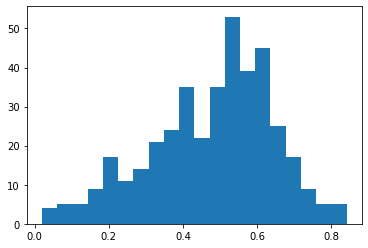

In [46]:
bleu_weights = [1.0, 0., 0., 0.]
pred_text_match_scores = compute_all_match_scores(val_data, pred_text, bleu_weights)
## plot scores
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(pred_text_match_scores, bins=20)
plt.show()

OK! The overlap actually isn't terrible at first glance, although we've seen [before](test_article_question_overlap.ipynb) that 0.9 is the cutoff for "correct" matches and this distribution doesn't look too great from that perspective.

In [47]:
## show best-scoring pairs
import pandas as pd
pred_text_scores = pd.DataFrame([val_target_text_combined, pred_text, pred_text_match_scores], index=['pred_text', 'target_text', 'match_score']).transpose()
pred_text_scores.sort_values('match_score', inplace=True, ascending=False)
display(pred_text_scores.head(20))

,pred_text,target_text,match_score
97,What does spokeswoman say about trial ?,What did the spokeswoman say about the case?,0.840909
2,What is included in Jackson 's trust ?,Who is included in Michael Jackson's trust?,0.837209
66,What did Gerrard admitted ?,What did Gerrard admit doing?,0.832849
215,What offers inst al ment plans ?,What are clients using to pay fees?,0.8
135,Which interstate was shut down ?,What interstate did the crash shut down?,0.8
260,What is home to the Space Wing ?,where is home to the 50th Space Wing?,0.78919
323,What do republic ans call Sonia S otom ...,What do some Republicans call Sonia Sotomayor?,0.780003
154,What strain has sick ened hundreds ?,What strain has caused hundreds to fall ill?,0.772727
7,Where did the train bombing occur ?,What number of people died in the bombing?,0.761905
249,What was Jackson looking to control ?,Who is looking for control in the article?,0.761905


- Question match: 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 = 50%

For such a small amount of data used in training, these results are actually pretty impressive! The question generation model must learn quickly.

After hard-coding the training process, we've trained the model on the full dataset. Let's see how the generation goes!!

In [89]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/CNN_articles/cnn/model_cache/'
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
# trained_model_state_dict_file = '../../data/CNN_articles/cnn/question_generation_model/pytorch_model.bin' # original/final model??
trained_model_state_dict_file = '../../data/CNN_articles/cnn/question_generation_model/checkpoint-120500/pytorch_model.bin' # checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
## load evaluation data
val_data_file = '../../data/CNN_articles/cnn/article_question_generation_val_data.pt'
val_data = torch.load(val_data_file)['train']

In [66]:
## TODO: try a smaller encoder/decoder?
# from transformers import AutoModelForSeq2SeqLM
# cache_dir = '../../data/CNN_articles/cnn/model_cache/'
# mini_generation_model = AutoModelForSeq2SeqLM.from_pretrained('sshleifer/bart-tiny-random', cache_dir=cache_dir)
# print(mini_generation_model)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 24, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 24, padding_idx=1)
      (embed_positions): LearnedPositionalEmbedding(1026, 24, padding_idx=1)
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): Attention(
            (k_proj): Linear(in_features=24, out_features=24, bias=True)
            (v_proj): Linear(in_features=24, out_features=24, bias=True)
            (q_proj): Linear(in_features=24, out_features=24, bias=True)
            (out_proj): Linear(in_features=24, out_features=24, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=24, out_features=16, bias=True)
          (fc2): Linear(in_features=16, out_features=24, bias=True)
          (final_layer_norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        )
        (1): EncoderLaye

In [84]:
import numpy as np
mini_val_data_size = 100
mini_val_data = val_data.select(np.array(list(range(mini_val_data_size))))
print(mini_val_data)

Dataset(features: {'source_text': Value(dtype='string', id=None), 'target_text': Value(dtype='string', id=None), 'source_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'target_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 100)


In [90]:
device_name = 'cpu'
pred_text = generate_predictions(generation_model, mini_val_data, device_name)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [91]:
## evaluate 
compare_pred_text_with_target(mini_val_data, pred_text)

*~*~*~*~*~*
source text = ( CNN )  --  The  parents  of  a  missing  10 - month - old  Missouri  girl  late  Thursday  indicated  they  are  cooperating  with  detectives ,  counter  to  what  police  said  earlier  in  the  evening ,  a  relative  said .    A  woman  who  identified  herself  as  Ashley  Irwin ,  sister  of...
target text = Lisa  Irwin 's  mother  says  the  girl  is  what ?
pred text = Do police say her parents are suspects?
*~*~*~*~*~*
source text = H AR ARE ,  Zimbabwe  ( CNN )    --  Zimbabwe 's  prime  minister  believes  the  driver  of  the  truck  that  struck  his  car ,  killing  his  wife ,  deliberately  drove  toward  them ,  his  party  told  CNN .    Morgan  Ts v ang ir ai  leaves  the  hospital  Saturday  after  being  treated  fo...
target text = What  type  of  accident  was  Morgan  Ts v ang ir ai  in ?
pred text = Where will Morgan Tsvangirai go on Wednesday?
*~*~*~*~*~*
source text = ( CNN )  --  The  investigation  of  the  E .  coli  outbreak  l

*~*~*~*~*~*
source text = LOS  ANGEL ES ,  California  ( CNN )  --  As  the  man  in  the  Dodgers  jersey  walked  quickly  around  the  perimeter  of  the  infield ,  fans  poured  down  from  the  ble achers  begging  for  aut ographs .    Pit bull  says  he  learns  from  setbacks :  " Usually  the  negatives  turned  ou...
target text = Wh ose  his  new  album  debuted  in  Top  10 ?
pred text = Who has Cuban heritage?
*~*~*~*~*~*
source text = ( CNN )  --  Capt .  Ches ley  S ull en berger ,  the  hero  pilot  who  safely  landed  a  full  passenger  jet  in  the  Hudson  River ,  was  once  again  honored  with  cheers  and  applause  Tuesday  during  a  ceremony  for  him  hosted  by  the  governor  of  his  home  state .    Gov .  Arno...
target text = Who  safely  landed  flight  15 49 ?
pred text = which is the name of the pilot?
*~*~*~*~*~*
source text = ( CNN )  --  An  Arizona  couple  who  wanted  to  adopt  a  woman 's  baby  know  more  than  they 're  saying  about  t

*~*~*~*~*~*
source text = ( CNN )  --  A  surrogate  mother  gave  birth  to  twin  girls  for  Sarah  Jessica  Parker  and  Matthew  Bro der ick ,  a  public ist  for  the  couple  said .    Sarah  Jessica  Parker  and  Matthew  Bro der ick  are  the  new  parents  of  twin  daughters .    " The  babies  are  doing  beautif...
target text = For  how  long  has  the  couple  been  married ?
pred text = Who had twin daughters?
*~*~*~*~*~*
source text = ( CNN )  --  Two  human - rights  activists  were  shot  and  killed  in  Kenya 's  capital ,  N airo bi ,  on  Thursday  evening ,  leading  a  U . N .  investigator  to  call  for  an  independent  investigation  to  prove  that  Kenyan  police  were  not  involved .    U . N .  inv es it g ator  ...
target text = Who  called  for  the  inquiry ?
pred text = What city did one student get fatally shot?
*~*~*~*~*~*
source text = ( CNN )  --  James  Cameron  unveiled  his  much - hyp ed ,  wildly - anticipated  3 D  sci - fi  epic  " Av at

*~*~*~*~*~*
source text = K abul ,  Afghanistan  ( CNN )  --  An  attack  in  which  the  Taliban  claimed  to  have  infiltrated  key  government  sites  in  downtown  Kabul  killed  at  least  five  people  Monday  morning ,  hospital  and  government  officials  said .    Among  the  five  were  two  policemen  and  one  ...
target text = How  many  insurgents  are  dead ?
pred text = where does the taliban enter?
*~*~*~*~*~*
source text = WASHINGTON  ( CNN )  --  Democratic  presidential  front - runner  Sen .  Barack  Obama  is  in  excellent  health ,  according  to  a  statement  from  his  doctor ,  released  by  the  campaign .    Besides  being  an  " inter mitt ent  smoker ,"  Sen .  Barack  Obama  is  in  excellent  health , ...
target text = Who  is  a  smoker ?
pred text = Who released his records last week?
*~*~*~*~*~*
source text = LOS  ANGEL ES ,  California  ( CNN )    --  A  1965  Volkswagen  van  stolen  35  years  ago  in  Spokane ,  Washington ,  was  found  by  c

*~*~*~*~*~*
source text = ( CNN )  --  The  U . S .  Coast  Guard  on  Thursday  is  searching  for  two  fishermen  missing  after  a  commercial  fishing  vessel  went  down  in  remote ,  treacherous  waters  off  the  Ale ut ian  Islands  about  1 , 400  miles  southwest  of  Anchorage ,  Alaska .    The  fishing  vessel...
target text = What  is  the  name  of  the  fishing  vessel ?
pred text = What is "The Katmai"?
*~*~*~*~*~*
source text = BER LIN ,  Germany  ( CNN )    --  Women 's  boxing  will  be  included  at  the  2012  Olympic  Games  in  London ,  the  president  of  the  International  Olympic  Committee  announced  Thursday .    Germany 's  In a  Men zer ,  left ,  fights  American  Franc hes ca  Al can ter  during  a  W IB ...
target text = Which  sport  will  be  included  in  2012  o lymp ics ?
pred text = Where were the games being held in 2012?
*~*~*~*~*~*
source text = A UR OR A ,  Colorado  ( CNN )  --  The  Atlanta  lawyer  with  tuberculosis  who  caused  an 

At first glance, the generated questions look plausible even if they're different from the target questions (e.g. swapping `when` questions for `what` questions about the same content).

Are the generated and target questions identical? We label yes/no.

- Question match: 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 = 8%

This is bad! Is the model overfitting to the training data? We won't know without looking at the train/validation losses.

What is overall distribution of question scores, and is this less bad than what we saw before?

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

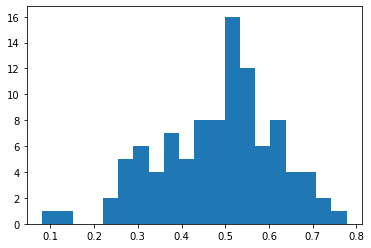

In [92]:
bleu_weights = [1.0, 0.0, 0.0, 0.0]
question_match_scores = compute_all_match_scores(mini_val_data, pred_text, bleu_weights)
## show distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(question_match_scores, bins=20)
plt.show()

Compared to the original distribution, it seems like we have a slightly more normal and less skewed distribution (higher mean)?

In [93]:
## rate the top-k questions
## get val data text for later
val_target_text_combined = []
special_tokens = set(['<pad>', '<s>', '</s>'])
for i, (batch_i) in enumerate(mini_val_data):
    target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
    target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
    # save target text for later qualitative comparisons
    val_target_text_combined.append(target_text_i)
import pandas as pd
pred_text_scores = pd.DataFrame([val_target_text_combined, pred_text, question_match_scores], index=['pred_text', 'target_text', 'match_score']).transpose()
pred_text_scores.sort_values('match_score', inplace=True, ascending=False)
display(pred_text_scores.head(20))

,pred_text,target_text,match_score
95,What did the administration plan ?,What had administration planned?,0.777215
92,Was the plane damaged ?,Was there any damages?,0.720059
56,When did Hollow ay disappear ?,Country where Holloway disappeared?,0.714286
74,what does Ring leader Greg Bell ch ambers ...,what happened to nearly every major golf brand...,0.693548
4,Where is the Carnival ?,What age is the dancer?,0.686906
35,What age is Steven Hutch ison ?,How long did Hutchison serve in the army?,0.682927
94,What has meditation helped to do ?,What is the third most popular religion in the...,0.68
7,what does the Video showed ?,What is the date of the incident?,0.666667
52,what does the policy undermine,What does the new TSA guidelines require?,0.658537
97,What do critics call it ?,Who was the bill inspired by?,0.655172


Even the high-scoring questions are not great and seem to have spurious connections (`Holloway` is match, `when` vs. `where` is not match).

TODO: What is the difference in training/validation loss?

We can't get the raw file open BUT we see using Tensorboard that the training loss does decrease monotonically.

- To replicate: on server `tensorboard --logdir=scripts/data_processing/runs/Dec02_01-00-39_lit1000/`; on local `ssh -N -f -L` to connect remotely

### Test question generation: user-generated questions
Let's see how well we can generate the same questions that people ask on NYT articles. 

H0: "Normal" generation model will struggle to predict user-generated comments, even after significant training, because the model lacks (1) theory of mind (2) shared common background/expectations with readers, which may be captured by additional background information (experience, geography, intent, etc.).

In [20]:
## load data
import os
import pandas as pd
import re
def load_all_scraped_articles(data_dir):
    article_files = list(map(lambda x: os.path.join(data_dir, x), os.listdir(data_dir)))
    article_data = pd.concat(list(map(lambda x: pd.read_csv(x, sep='\t', index_col=False), article_files)), axis=0)
    article_id_matcher = re.compile('(?<=article_)[0-9a-zA-Z]+(?=\.tsv)')
    article_ids = list(map(lambda x: article_id_matcher.search(x).group(0), article_files))
    article_data = article_data.assign(**{
        'article_id' : article_ids
    })
    return article_data
def clean_text_body(txt, word_tokenizer, matcher_pairs):
    clean_txt = ' '.join(word_tokenizer.tokenize(txt))
    for matcher_i, sub_i in matcher_pairs:
        clean_txt = matcher_i.sub(sub_i, clean_txt)
    return clean_txt
from nltk.tokenize import sent_tokenize, WordPunctTokenizer
def load_all_comment_questions(comment_dir, comment_month_years=[('April', '2018')]):
    comment_files = list(map(lambda x: f'Comments{x[0]}{x[1]}.csv', comment_month_years))
    comment_files = list(map(lambda x: os.path.join(comment_dir, x), comment_files))
    comment_data = []
    for comment_file_i in comment_files:
        comment_data_i = pd.read_csv(comment_file_i, sep=',', index_col=False, usecols=['articleID', 'approveDate', 'commentBody', 'commentType', 'parentID', 'userLocation', 'userID', 'userDisplayName'])
        comment_data.append(comment_data_i)
    comment_data = pd.concat(comment_data, axis=0)
    # remove duplicates? OK
    comment_data.drop_duplicates(['articleID', 'commentBody'], inplace=True)
    # clean text => fix punctuation without spaces and HTML
#     html_matcher = re.compile('<.+>')
    matcher_pairs = [(re.compile('<.+>'), ' <HTML> '), 
                     (re.compile('\.{2,}'), '.'),
                     (re.compile(' \- '), '-'), 
                     (re.compile(' ([\.\?\!,\'\"]+)'), '\\1'), 
                     (re.compile('([\']) (?=[a-z])'), '\\1'), # fix contraction spacing
                     (re.compile('(\() '), '\\1'), (re.compile(' (\))'), '\\1')]
    word_tokenizer = WordPunctTokenizer()
    comment_data = comment_data.assign(**{
        'commentBody' : comment_data.loc[:, 'commentBody'].apply(lambda x: clean_text_body(x, word_tokenizer, matcher_pairs))
    })
#     a_1 = html_matcher.sub('<HTML>', a)
#     # fix spaces before punctuation
#     a_1 = ' '.join(word_tokenizer.tokenize(a_1))
#     for punct_matcher_i, punct_i in punct_matchers:
#         a_1 = punct_matcher_i.sub(punct_i, a_1)
    # find questions
    question_matcher = re.compile('\?$')
    comment_data = comment_data.assign(**{
        'comment_questions' : comment_data.loc[:, 'commentBody'].apply(lambda x: list(filter(lambda y: question_matcher.search(y) is not None, sent_tokenize(x))))
    })
    # convert to question data (one row/question)
    question_data = []
    question_cols = ['approveDate', 'articleID', 'commentBody', 'commentType', 'parentID', 'userID', 'userLocation', 'userDisplayName']
    for idx_i, data_i in comment_data.iterrows():
        for question_j in data_i.loc['comment_questions']:
            question_data.append(pd.Series(data_i.loc[question_cols].append(pd.Series([question_j], index=['question']))))
    question_data = pd.concat(question_data, axis=1).transpose()
    question_data.rename(columns={'articleID':'article_id'}, inplace=True)
    ## TODO: clean short/malformed questions
    min_question_len = 6
    question_data = question_data.assign(**{
        'question_len' : question_data.loc[:, 'question'].apply(lambda x: len(word_tokenizer.tokenize(x)))
    })
    question_data = question_data[question_data.loc[:, 'question_len'] >= min_question_len]
#     html_matcher = re.compile('<[^>]+>.+<[^>]+/>')
#     html_matcher = re.compile('<.+>')
#     question_data = question_data.assign(**{
#         'comment_question' : question_data.loc[:, 'comment_question'].apply(lambda x: html_matcher.sub('<HTML>', x))
#     })
    ## 
    return question_data
nyt_data_dir = '../../data/NYT_scrape/'
nyt_article_data = load_all_scraped_articles(nyt_data_dir)
nyt_comment_dir = '../../data/nyt_comments/'
comment_month_years = [('April', '2018')]
nyt_question_data = load_all_comment_questions(nyt_comment_dir, comment_month_years=comment_month_years)

In [21]:
print(f'{nyt_question_data.shape[0]} questions')
display(nyt_question_data.head())
display(nyt_question_data.sort_values('question_len', inplace=False, ascending=True).loc[:, 'question'].head(10).values)

70899 questions


,approveDate,article_id,commentBody,commentType,parentID,userID,userLocation,userDisplayName,question,question_len
0,1524594282,5adf6684068401528a2aa69b,How could the league possibly refuse this offer?,comment,0,4.65667e+07,San Francisco,Christopher Rillo,How could the league possibly refuse this offer?,9
1,1524593431,5adf6684068401528a2aa69b,Could the cheerleaders join the Actors' Equity...,comment,0,8.19396e+07,"Phoenix, AZ",Stephen,Could the cheerleaders join the Actors' Equity...,15
2,1524583914,5adf4626068401528a2aa628,Did this remind me of Joyce? <HTML> Well don...,comment,0,3.8909e+07,"BK, NY",Dustin R.,Did this remind me of Joyce?,7
5,1524591916,5adf40d2068401528a2aa619,One has to wonder-does Trump have even a basic...,comment,0,7.69947e+07,CA,John Adams,One has to wonder-does Trump have even a basic...,17
6,1524591916,5adf40d2068401528a2aa619,Truly the most disgusting display of faux brom...,comment,0,5.69492e+07,old lyme ct.,susan mccall,"Why does trump do that aggressive, pull victim...",14


array(['I am so malleable that?', 'Would you do this favour?',
       'Orba multi-racial one?', 'So who are the racist?',
       'Could you be more specific?', 'How is that fiscally responsible?',
       'Why is this so hard?', 'Will he ever fess up?',
       'What can possibly go wrong?', 'David, are you serious?'],
      dtype=object)

After preparing data and training, let's see what questions the model has learned to generate.

In [22]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/nyt_comments/model_cache/'
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
trained_model_state_dict_file = '../../data/nyt_comments/question_generation_model/checkpoint-97000/pytorch_model.bin' # checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
## load evaluation data
val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.pt'
val_data = torch.load(val_data_file)['train']

In [ ]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import generate_predictions
device_name = 'cuda:0'
pred_text = generate_predictions(generation_model, val_data, tokenizer, device_name)

  0%|          | 0/9713 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
 74%|███████▍  | 7227/9713 [20:25<06:44,  6.15it/s]

In [95]:
import numpy as np
mini_val_data_size = 100
mini_val_data = val_data.select(np.array(list(range(mini_val_data_size))))
mini_pred_text = pred_text[:mini_val_data_size]

In [96]:
## look at questions manually first
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import compare_pred_text_with_target
compare_pred_text_with_target(mini_val_data, mini_pred_text, tokenizer)

*~*~*~*~*~*
source text = P un itive  airstrikes  by  the  US  and  the  West  again .  Does  it  really  matter  if  the  airstrikes  are  by  Assad ,  the  US ,  Russia ,  Iran  and  now  Israel ?  The  result  is  the  same .  It  is  the  Syrians  who  are  punished .  Period .  What  have  they  done  to  be  punished ?...
target text = Does  it  really  matter  if  the  airstrikes  are  by  Assad ,  the  US ,  Russia ,  Iran  and  now  Israel ?
pred text = What have they done to be punished?
*~*~*~*~*~*
source text = What  deals  have  Mr .  Cohen  done  for  Mr .  Hannity ?  To  what  extent  do  Mr .  Trump  and  Mr .  Hannity  have  deals  arranged  by  Mr .  Cohen ?  I  hope  the  prosecutors  can  look  into  these  matters  for  criminal  corruption .  For  example ,  to  what  extent  have  Fox  News  and...
target text = For  example ,  to  what  extent  have  Fox  News  and  Mr .  Hannity  been  supported  by  Russians ?
pred text = To what extent do Mr. Trump and Mr. Ha

*~*~*~*~*~*
source text = So ,  which  countries  have  a  moral  right  to  exist  in  your  opinion ?  And  which  don 't ?...
target text = And  which  don 't ?
pred text = So, which countries have a moral right to exist in your opinion?
*~*~*~*~*~*
source text = Don 't  be  naive .  The  reality  is  that  there  has  always  been  a  law  for  the  rich  and  a  law  for  the  poor .  If  you  are  rich  enough  you  can  afford  a  better  lawyer  which  will  affect  how  you  do  in  the  courtroom .  We 've  seen  it  time  and  time  again  with  whit...
target text = How  many  times  has  he  gotten  away  with  fraud  and  outright  theft ?
pred text = How many times has he been sued?
*~*~*~*~*~*
source text = So  why  do  ads  for  products  I  just  searched  for  appear  on  my  NYT IM ES  news  feed ?...
target text = So  why  do  ads  for  products  I  just  searched  for  appear  on  my  NYT IM ES  news  feed ?
pred text = So why do ads for products I just searched f

*~*~*~*~*~*
source text = And  THAT  is  why ,  in  his  next  opinion  piece ,  Stephens  will  post  an  open  letter  to  the  National  Review  demanding  it  welcomes  a  progressive  editor  to  its  staff .  < HTML >    What  better  way  to  encourage  open - minded ness  than  to  model  the  tolerance  of  opposing...
target text = < HTML >    What  better  way  to  encourage  open - minded ness  than  to  model  the  tolerance  of  opposing  viewpoints  that  virtually  defines  right  wing  thought  in  America ?
pred text = <HTML>  What better way to encourage open-mindedness than to model the tolerance of opposing viewpoints that virtually defines right wing thought in America?
*~*~*~*~*~*
source text = "  all  the  political  turmoil  is  creating  a  burst  of  intellectual  creativity  on  the  right ."  Creat ivity  can  also  be  used  to  create  fiction .  Creat ivity  also  brought  us  CD Os  and  other  creative  financial  instruments .  Creat ivity  has  broug

*~*~*~*~*~*
source text = We  have  a  congressional  oversight  committee ,  which  is  not  following  through  on  its  mission .  How  much  money  is  being  spent  on  presidential  travel  back  and  forth  to  Mar  a  L ago ?  By  the  entire  Trump  family ?  Himself ,  his  wife ,  his  children .  < HTML >    How ...
target text = < HTML >    How  much  money  is  being  spent  by  all  the  cabinet  secretaries  on  travel  and  office  expenses ?
pred text = By the entire Trump family?
*~*~*~*~*~*
source text = Why  not  just  raise  taxes  to  upgrade  the  system ?  Problem  solved !...
target text = Why  not  just  raise  taxes  to  upgrade  the  system ?
pred text = Why not just raise taxes to upgrade the system?
*~*~*~*~*~*
source text = She  got  money  from  Trump 's  lawyer  for  no  reason  without  his  knowledge ?  Is  that  what  you  want  us  to  think ?...
target text = Is  that  what  you  want  us  to  think ?
pred text = She got money from Trump's lawyer 

*~*~*~*~*~*
source text = I  assume  the  woman  involved  is  very  attractive .  This  man  is  not .  Do  these  women  have  such  little  self  respect  that  they  are  willing  to  engage  in  a  relationship  with  this  old ,  fat  and  morally  bankrupt  men ?  Or  is  it  that  they  love  the  color  of  their  m...
target text = Or  is  it  that  they  love  the  color  of  their  money ?
pred text = Do these women have such little self respect that they are willing to engage in a relationship with this old, fat and morally bankrupt men?
*~*~*~*~*~*
source text = Here 's  what  I 'm  not  getting .  If  total  population  is  used  to  determine  congressional  seats ,  votes  in  the  electoral  college - then  counting  those  who  are  not  citizens  in  the  total  population  seems  --  totally  wrong .  If  you  don 't  have  the  right  to  vote  beca...
target text = If  I 'm  a  citizen  of  say  Kansas ,  and  I 'm  not  getting  as  many  congressional  seats  a

*~*~*~*~*~*
source text = To  all  those  who  criticize  California  for  whatever  reason ,  whether  raising  clean  air  standards ,  sanctuary  cities ,  heightened  awareness  and  protection  of  LGBTQ  citizens ,  legalized  marijuana  for  medical  and  recreation  purposes ,  protection  of  a  woman 's  right  to ...
target text = To  all  those  who  criticize  California  for  whatever  reason ,  whether  raising  clean  air  standards ,  sanctuary  cities ,  heightened  awareness  and  protection  of  LGBTQ  citizens ,  legalized  marijuana  for  medical  and  recreation  purposes ,  protection  of  a  woman 's  right  to  choose ,  solid  credits  for  solar  installations  and  a  stress  on  alternative  renewable  fuels  —  to  all  of  those  critics
pred text = To all those who criticize California for whatever reason, whether raising clean air standards, sanctuary cities, heightened awareness and protection of LGBTQ citizens, legalized marijuana for medical and rec

What if we make the prediction task a little easier? 

Let's compute the maximium overlap score between the generated question and all questions for a given article, and use that as our test score.

In [5]:
import numpy as np
from data_helpers import generate_predictions, compute_text_bleu
def compute_max_overlap(model, batch_data, raw_data, tokenizer, device_name='cpu'):
    # assume that batch data and raw data align
    article_ids = raw_data.loc[:, 'article_id'].nunique()
    score_weights = [1.0, 0., 0., 0.]
    score_data = []
    for article_id_i in tqdm(article_ids):
        idx_i = np.where(raw_data.loc[:, 'article_id'] == article_id_i)[0]
        batch_data_i = batch_data.select(idx_i)
        batch_data_to_generate_i = batch_data.select(idx_i[0])
        # generate question for the article
        pred_text_i = generate_predictions(model, batch_data_to_generate_i, tokenizer, device_name=device_name)
        # compute overlap score for all target
        overlap_scores_i = []
        for batch_data_j in batch_data_i:
            target_i = batch_data_j['target_ids']
            target_txt_i = tokenizer.decode(target_i, skip_special_tokens=True)
            overlap_score_i = compute_text_bleu(target_txt_i, pred_text_i, weights=score_weights)
            overlap_scores_i.append(overlap_score_i)
        max_overlap_score_i = max(overlap_scores_i)
        max_overlap_target_i = np.argmax(overlap_scores_i)
        input_ids_i = batch_data_i['source_ids']
        input_txt_i = tokenizer.decode(input_ids, skip_special_tokens=True)
        score_data.append([input_text_i, pred_text_i, max_overlap_score_i, max_overlap_target_i])
    return score_data

In [12]:
import torch
import pandas as pd
val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.pt'
raw_val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.csv'
val_data = torch.load(val_data_file)['train']
raw_val_data = pd.read_csv(raw_val_data_file, sep=',', index_col=False)

In [17]:
raw_val_data.head()

,source_text,target_text
0,"James Comey's book is titled"" A Higher Loyalty...",How could such a bright man fail to see this?
1,WASHINGTON -- The F. B. I. raided the Rockefel...,Did someone leak to them that Trump is now a t...
2,"This week, Facebook's chief executive, Mark Zu...",<HTML> Perhaps we need a similar law for our ...
3,"From his Fox News pulpit, Sean Hannity has bee...",Isn't revealing the name of a client a breach ...
4,"So far, running for a third term as governor o...",I wish some things about Mr. Cuomo's record we...


In [15]:
max_score_data = compute_max_overlap(generation_model, val_data, raw_val_data)

'The Reader Center is one way we in the newsroom are trying to connect with you, by highlighting your perspectives and experiences and offering insight into how we work. There ’ s an app for that, but I ’ m not sure anyone cares anymore. That thought was stuck in my head when I pitched the idea for Tech We ’ re Using, a column about how New York Times journalists use tech in their jobs and personal lives. Over the last decade, smartphones have become the center of how we consume and create media. Apps used to be a novelty ; there was a period of time when smartphones were young and we were excited about finding new apps to download. But by now, there are millions of apps for smartphones, and people have found and settled on the tools that are the most useful to them. So what are people doing with tech now that it ’ s become such a personalized commodity tailored to their lives? My editor and I decided to invite members of The New York Times from every corner of the newsroom to riff abo

TODO: We can "cue" the system with the first word of the question to make a better comparison, e.g. comparing "who" questions fairly.

In [ ]:
def beam_search_with_decoder_input(self,
        input_ids: torch.LongTensor,
        beam_scorer: BeamScorer,
        logits_processor: Optional[LogitsProcessorList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[int] = None,
        **model_kwargs):
    """
    Do beam search using 
    """
    ## copied from https://huggingface.co/transformers/_modules/transformers/generation_utils.html#GenerationMixin.beam_search
    # init values
    logits_processor = logits_processor if logits_processor is not None else LogitsProcessorList()
    max_length = max_length if max_length is not None else self.config.max_length
    pad_token_id = pad_token_id if pad_token_id is not None else self.config.pad_token_id
    eos_token_id = eos_token_id if eos_token_id is not None else self.config.eos_token_id

    batch_size = len(beam_scorer._beam_hyps)
    num_beams = beam_scorer.num_beams

    batch_beam_size, cur_len = input_ids.shape

    assert (
        num_beams * batch_size == batch_beam_size
    ), "Batch dimension of `input_ids` should be {num_beams * batch_size}, but is {batch_beam_size}."

    beam_scores = torch.zeros((batch_size, num_beams), dtype=torch.float, device=input_ids.device)
    beam_scores[:, 1:] = -1e9
    beam_scores = beam_scores.view((batch_size * num_beams,))

    while cur_len < max_length:
        model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

        outputs = self(**model_inputs, return_dict=True)
        next_token_logits = outputs.logits[:, -1, :]

        # adjust tokens for Bart, *e.g.*
        next_token_logits = self.adjust_logits_during_generation(
            next_token_logits, cur_len=cur_len, max_length=max_length
        )

        next_token_scores = F.log_softmax(next_token_logits, dim=-1)  # (batch_size * num_beams, vocab_size)

        next_token_scores = logits_processor(input_ids, next_token_scores)
        next_token_scores = next_token_scores + beam_scores[:, None].expand_as(next_token_scores)
        # reshape for beam search
        vocab_size = next_token_scores.shape[-1]
        next_token_scores = next_token_scores.view(batch_size, num_beams * vocab_size)

        next_token_scores, next_tokens = torch.topk(
            next_token_scores, 2 * num_beams, dim=1, largest=True, sorted=True
        )

        next_indices = next_tokens // vocab_size
        next_tokens = next_tokens % vocab_size

        # stateless
        beam_outputs = beam_scorer.process(
            input_ids,
            next_token_scores,
            next_tokens,
            next_indices,
            pad_token_id=pad_token_id,
            eos_token_id=eos_token_id,
        )
        beam_scores = beam_outputs["next_beam_scores"]
        beam_next_tokens = beam_outputs["next_beam_tokens"]
        beam_idx = beam_outputs["next_beam_indices"]

        input_ids = torch.cat([input_ids[beam_idx, :], beam_next_tokens.unsqueeze(-1)], dim=-1)
        cur_len = cur_len + 1

        model_kwargs = self._update_model_kwargs_for_generation(
            outputs, model_kwargs, is_encoder_decoder=self.config.is_encoder_decoder
        )
        if model_kwargs["past"] is not None:
            model_kwargs["past"] = self._reorder_cache(model_kwargs["past"], beam_idx)

        if beam_scorer.is_done:
            break

    decoded = beam_scorer.finalize(
        input_ids, beam_scores, next_tokens, next_indices, pad_token_id=pad_token_id, eos_token_id=eos_token_id
    )

    return decoded

def generate_with_decoder_input():
    """
    Generate text with decoder input provided (assume beam search for simplicity).
    Stolen from https://huggingface.co/transformers/_modules/transformers/generation_utils.html#GenerationMixin.generate
    """
    # set init values
    num_beams = num_beams if num_beams is not None else self.config.num_beams
    max_length = max_length if max_length is not None else self.config.max_length
    do_sample = do_sample if do_sample is not None else self.config.do_sample
    num_return_sequences = (
        num_return_sequences if num_return_sequences is not None else self.config.num_return_sequences
    )

    pad_token_id = pad_token_id if pad_token_id is not None else self.config.pad_token_id
    bos_token_id = bos_token_id if bos_token_id is not None else self.config.bos_token_id
    eos_token_id = eos_token_id if eos_token_id is not None else self.config.eos_token_id

    if input_ids is None:
        # init `input_ids` with bos_token_id
        input_ids = self._prepare_input_ids_for_generation(bos_token_id)

    if model_kwargs.get("attention_mask", None) is None:
        # init `attention_mask` depending on `pad_token_id`
        model_kwargs["attention_mask"] = self._prepare_attention_mask_for_generation(
            input_ids, pad_token_id, eos_token_id
        )

    # special case if pad_token_id is not defined
    if pad_token_id is None and eos_token_id is not None:
        logger.warning(f"Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation.")
        pad_token_id = eos_token_id

    if self.config.is_encoder_decoder:
        # add encoder_outputs to model_kwargs
        model_kwargs = self._prepare_encoder_decoder_kwargs_for_generation(input_ids, model_kwargs)

        # set input_ids as decoder_input_ids
        input_ids = self._prepare_decoder_input_ids_for_generation(
            input_ids, decoder_start_token_id=decoder_start_token_id, bos_token_id=bos_token_id, **model_kwargs
        )

        if "encoder_outputs" not in model_kwargs or not isinstance(model_kwargs["encoder_outputs"], ModelOutput):
            raise ValueError("Make sure that `model_kwargs` include `encoder_outputs` of type `ModelOutput`.")

    # determine generation mode
    is_greedy_gen_mode = (num_beams == 1) and do_sample is False
    is_sample_gen_mode = (num_beams == 1) and do_sample is True
    is_beam_gen_mode = (num_beams > 1) and do_sample is False
    is_beam_sample_gen_mode = (num_beams > 1) and do_sample is True

    # set model_kwargs
    model_kwargs["use_cache"] = use_cache

    # get distribution pre_processing samplers
    logits_processor = self._get_logits_processor(
        repetition_penalty=repetition_penalty,
        no_repeat_ngram_size=no_repeat_ngram_size,
        bad_words_ids=bad_words_ids,
        min_length=min_length,
        eos_token_id=eos_token_id,
        prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
        num_beams=num_beams,
    )
    batch_size = input_ids.shape[0]

    length_penalty = length_penalty if length_penalty is not None else self.config.length_penalty
    early_stopping = early_stopping if early_stopping is not None else self.config.early_stopping

    if num_return_sequences > num_beams:
        raise ValueError("`num_return_sequences` has to be smaller or equal to `num_beams`.")

    beam_scorer = BeamSearchScorer(
        batch_size=batch_size,
        max_length=max_length,
        num_beams=num_beams,
        device=self.device,
        length_penalty=length_penalty,
        do_early_stopping=early_stopping,
        num_beam_hyps_to_keep=num_return_sequences,
    )
    # interleave with `num_beams`
    input_ids, model_kwargs = self._expand_inputs_for_generation(
        input_ids, expand_size=num_beams, is_encoder_decoder=self.config.is_encoder_decoder, **model_kwargs
    )
    return self.beam_search(
        input_ids,
        beam_scorer,
        logits_processor=logits_processor,
        max_length=max_length,
        pad_token_id=pad_token_id,
        eos_token_id=eos_token_id,
        **model_kwargs,
    )
    pass

def generate_predictions_with_decoder_input(model, data, tokenizer, cue_ids, device_name='cpu'):
    num_beams = 4
    max_decoding_length = 64
    length_penalty = 1
    device = torch.device(device_name)
    model.to(device)
    pred_text = []
    for batch_i in tqdm(data):
        source_i = batch_i['source_ids']
        attention_i = batch_i['attention_mask']
        target_i = batch_i['target_ids']
        # fix type in case of difference
        if(type(source_i) is list):
            source_i = torch.LongTensor(source_i)
        if(type(attention_i) is list):
            attention_i = torch.Tensor(attention_i)
        if(type(target_i) is list):
            
            pass
        output_i = generate_with_cue(
            model,
            input_ids=source_i.to(device).reshape(1,-1),
            attention_mask=attention_i.to(device).reshape(1,-1),
            num_beams=num_beams,
            max_length=max_decoding_length,
            length_penalty=length_penalty,
            cue_output_ids=[],
        )
        prediction = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_i]
        pred_text.extend(prediction)
    return pred_text